# Purpose and motivation <B>
As an extension to my previous work on trend analysis and following, this notebook explores the functional ideas behind "Modern Portfolio Theory" (or "mean-variance analysis"), as first presented Harry Markowitz in 1952 (https://en.wikipedia.org/wiki/Modern_portfolio_theory). The work in this notebook goes through the theoretical buildingblocks, but it has the aim of producing a practical understanding of the concepts, so that operational software can be build on top of the theoretical concepts. That means, that I will _not_ go deeply into the mathematical concepts, but for my own future reference, I _will_ however include a brief conceptual description, so that the most basic documentation is in place.


In [2]:
import sys
sys.version
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib
from collections import OrderedDict 
import matplotlib.pyplot as plt

## Picking the portfolio assets
For building a portfolio, I will ofcourse need a collection of assets to consider, and for illustrating the portfolio ballancing concepts, I have chosen assets of different apparent volatility. The reason for this is, that the process of portfolio ballancing is actually the process of balancing risk against reward, and since risk in this case is considered to be synonymous with volatility, it illustrates the points best, if volatilities are diverse.<br><br>
This is not quite the same goal as in my previous trend following project, where the aim was to find assets that have smooth trends over time. Hence, in this case I have chosen assets that you would expect to have relativly stable prices over time (such as gold) but also assets that have relatively high prica volatility, eg. the TSLA stock.

## Data download
For this project, I have chosen to use another dataprovider than previous projects, since the api´s at aphavantage.com apparently has dataquality issues, when it comes to "recent" historical data. The <b>pandas_datareader</b> (https://pandas-datareader.readthedocs.io/en/latest/) enables download of historical prices from Yahoo and other data providers (incl. by the way, AplhaVantage)

In [6]:
# Read Data
symbols = OrderedDict()
symbols['IQQH.DE'] = 'iShares Global Clean Energy UCITS ETF USD'
symbols['TLT'] = 'iShares 20 Plus Year Treasury Bond ETF'
symbols['GLD'] = 'SPDR Gold Trust'
symbols['SPY'] = 'SPDR S&P 500 ETF Trust'
symbols['QQQ'] = 'Invesco QQQ Trust Series 1 ETF'
symbols['VWO'] = 'Vanguard Emerging Markets Stock Index Fund ETF'
symbols['IUSR.DE']='EURO STOXX 50 ex-Finanance' # DE: Frankfurt traded
symbols['SXRW.DE']='FTSE 100 UK'
symbols['TDC']='Teradata Corporation' 
symbols['IWY']='iShares Russell Top 200 Growth ETF' 



ticker_data = data.DataReader(list(symbols.keys()), 'yahoo', start='2017/01/01', end='2020/12/31')['Adj Close']

In [7]:
ticker_data.head()

Symbols,IQQH.DE,TLT,GLD,SPY,QQQ,VWO,IUSR.DE,SXRW.DE,TDC,IWY
Date,,,,,,,,,,
2017-01-02,4.449,NaN,NaN,NaN,NaN,NaN,31.799999,121.529999,NaN,NaN
2017-01-03,4.468,108.093025,110.470001,206.871796,115.439812,31.990612,31.700001,121.870003,27.580000,53.915909
2017-01-04,4.510,108.508621,110.860001,208.102493,116.067528,32.282486,31.670000,121.669998,28.639999,54.276924
2017-01-05,4.483,110.207207,112.580002,207.937195,116.724190,32.618572,31.730000,121.589996,28.340000,54.476448
2017-01-06,4.501,109.195312,111.750000,208.681137,117.747833,32.485905,31.760000,121.250000,28.750000,54.865963


## Data cleanup
The pandas datareader will build a column for each ticker in the list, eventhough it might not find data for some of them. I choose to drop the data columns entirely. Since individual days (or sub-periodes) might still be missing data, I will use backfill to simulate the missing data. Note, that there might be better techniques for this, but for the time being, this will do.

In [8]:
ticker_data = ticker_data.dropna(axis=1, how='all')
ticker_data=ticker_data.fillna(method='backfill') # Backfill missing data
ticker_data.head()

Symbols,IQQH.DE,TLT,GLD,SPY,QQQ,VWO,IUSR.DE,SXRW.DE,TDC,IWY
Date,,,,,,,,,,
2017-01-02,4.449,108.093025,110.470001,206.871796,115.439812,31.990612,31.799999,121.529999,27.580000,53.915909
2017-01-03,4.468,108.093025,110.470001,206.871796,115.439812,31.990612,31.700001,121.870003,27.580000,53.915909
2017-01-04,4.510,108.508621,110.860001,208.102493,116.067528,32.282486,31.670000,121.669998,28.639999,54.276924
2017-01-05,4.483,110.207207,112.580002,207.937195,116.724190,32.618572,31.730000,121.589996,28.340000,54.476448
2017-01-06,4.501,109.195312,111.750000,208.681137,117.747833,32.485905,31.760000,121.250000,28.750000,54.865963


I have built a dictionary of tickers, that controls datadownload. As I will be using the same dictionary later for  other purposes, it is important, that it is in sync with data, even after having droped columns with all null values

In [9]:
# Check if all tickers exist in the period.
tickers = symbols.keys()
for s in tickers:
    if not s.upper() in [t.upper() for t in list(ticker_data.columns)]:
        symbols.pop(s)
        print('Warning, {} is not in ticker data'.format(s))
symbols

OrderedDict([('IQQH.DE', 'iShares Global Clean Energy UCITS ETF USD'),
             ('TLT', 'iShares 20 Plus Year Treasury Bond ETF'),
             ('GLD', 'SPDR Gold Trust'),
             ('SPY', 'SPDR S&P 500 ETF Trust'),
             ('QQQ', 'Invesco QQQ Trust Series 1 ETF'),
             ('VWO', 'Vanguard Emerging Markets Stock Index Fund ETF'),
             ('IUSR.DE', 'EURO STOXX 50 ex-Finanance'),
             ('SXRW.DE', 'FTSE 100 UK'),
             ('TDC', 'Teradata Corporation'),
             ('IWY', 'iShares Russell Top 200 Growth ETF')])

## Visualizing data
Visualizing is _always_ a good idea, to get a sense of the data that you are working with, so to begin with, I´ll plot the price time-series for the individual assets chosen. This is basic pandas (matplotlib) plotting - other methods exist, that are more easy on the eye :-) 

<AxesSubplot:xlabel='Date'>

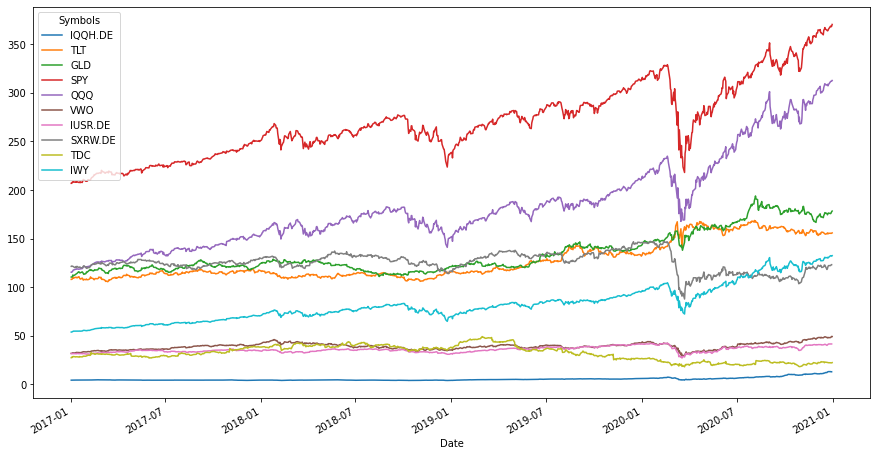

In [10]:
ticker_data.plot(figsize=(15,8))

## MPT (Modern Portfolio Theory) 
MPT deals with optimizing expected return and minimizing expected risk on a portfolio. Therefor, we need a couple of components to build this optimization

* Expected risk of inidividual assets (in this case: risk = volatility = std. dev. of fluctuations in price)
* Correlations between asset fluctuations, since correlations increses or decreases total risk
* Expected return of individual assets


## We will start with risk, which means looking at volatility:
Let´s calculate the daily change in price <br>
To make the measures "time additive", we´ll take the log of the daily relative changes, to calculate compunded return. For in-depth of the concept of "log returns" in investment, please consult https://investmentcache.com/magic-of-log-returns-concept-part-1

In [11]:
for i, symbol in enumerate(symbols):
    if i == 0:
        returns = pd.DataFrame(ticker_data[symbol].pct_change().apply(lambda x: np.log(1+x)))
    else:
        returns[symbol] = ticker_data[symbol].pct_change().apply(lambda x: np.log(1+x))
returns.head()

,IQQH.DE,TLT,GLD,SPY,QQQ,VWO,IUSR.DE,SXRW.DE,TDC,IWY
Date,,,,,,,,,,
2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,0.004262,0.000000,0.000000,0.000000,0.000000,0.000000,-0.003150,0.002794,0.000000,0.000000
2017-01-04,0.009356,0.003837,0.003524,0.005931,0.005423,0.009082,-0.000947,-0.001642,0.037713,0.006674
2017-01-05,-0.006005,0.015533,0.015396,-0.000795,0.005642,0.010357,0.001893,-0.000658,-0.010530,0.003669
2017-01-06,0.004007,-0.009224,-0.007400,0.003571,0.008732,-0.004076,0.000945,-0.002800,0.014364,0.007125


## Lets take an initial look at volatility
It seems, that volatility generally exploded around spring 2020 and late 2020. This should come as no surprise, since these are also periods of the first and second wave of the sars-cov-2 pandemic, which has impacts on financial markets.

<AxesSubplot:xlabel='Date'>

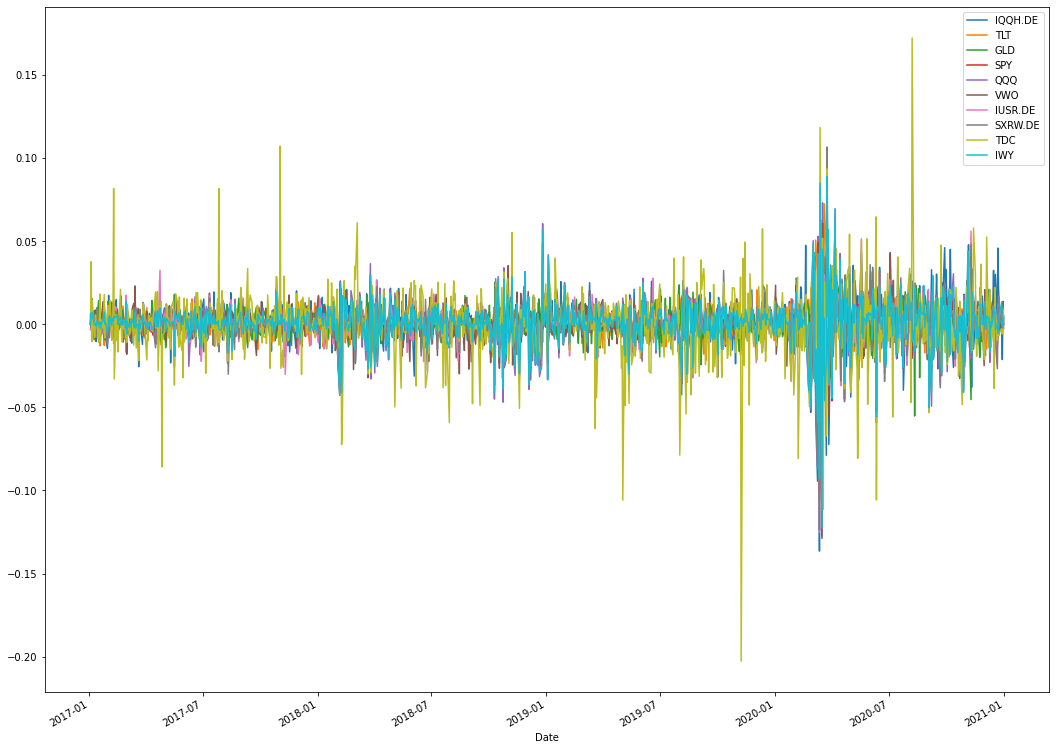

In [12]:
returns.plot(figsize=(18,14))

## Now, onto variance
The steps in calculating risk on individual assets are
* is calculating daily variance <br>
* since we want risk on a yearly basis, so we, so we will have to ajust the daily variance to yearly
* As mentioned, we want the measured as standard deviation, so we will go from yearly variance to std. dev. by taking the sqrt.

In [13]:
covariance_matrix = returns.cov()
covariance_matrix.head()

,IQQH.DE,TLT,GLD,SPY,QQQ,VWO,IUSR.DE,SXRW.DE,TDC,IWY
IQQH.DE,0.000221,-0.000029,0.000007,0.000102,0.000101,0.000110,0.000123,0.000133,0.000105,0.000099
TLT,-0.000029,0.000076,0.000022,-0.000046,-0.000045,-0.000037,-0.000025,-0.000033,-0.000040,-0.000043
GLD,0.000007,0.000022,0.000069,0.000004,0.000009,0.000016,0.000003,0.000002,-0.000008,0.000008
SPY,0.000102,-0.000046,0.000004,0.000158,0.000169,0.000137,0.000088,0.000095,0.000147,0.000162
QQQ,0.000101,-0.000045,0.000009,0.000169,0.000211,0.000152,0.000083,0.000085,0.000153,0.000193


In [14]:
#For individuaal variances, we can extract them from the co-variance matrix diagonal:
symbol_list = list(symbols.keys())
variances=pd.DataFrame(pd.Series([float(covariance_matrix[covariance_matrix.index==symbol][symbol]) for symbol in symbol_list])).set_index([symbol_list])
variances.columns=['variance']
variances.head()

,variance
IQQH.DE,0.000221
TLT,0.000076
GLD,0.000069
SPY,0.000158
QQQ,0.000211


## In this case, risk equals volitility equals standard deviation in price change
But to get the yearly risk, eg. the yearly std. dev., we´ll multiply the variance by 250 trading days, which gives us the yearly variance. To go from variance to std. dev, we´ll take the square root. To illustrate the difference in volatility, aka risk, I´ll plot the newly calculated standard deviation in price for each asset.

In [15]:
variances['stddev'] = np.sqrt(variances['variance']*250)
variances.head()

,variance,stddev
IQQH.DE,0.000221,0.234986
TLT,0.000076,0.137907
GLD,0.000069,0.131082
SPY,0.000158,0.198497
QQQ,0.000211,0.229925


## Let´s illustrate the differences in risk

<AxesSubplot:>

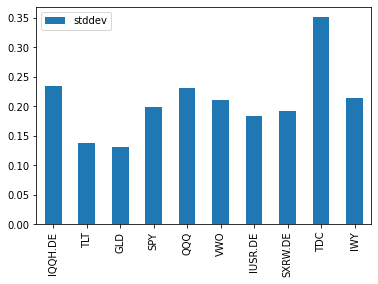

In [16]:
variances[['stddev']].plot(kind='bar')

## From individual asset risk to portfolio risk
I need to calculate total risk of a portfolio, and this, I´ll define a portfolio as a collection of assets and their weights. Different portfolios can ofcourse have different weights, but to begin with, I will generate ramdom weights for one portfolio.

<i>"The Dirichlet takes a vector of parameters, one for each variate (of which there can be 2 to infinity). The output of the distribution is such that the sum of the variables always equals one — for example, in a 3-dimensional Dirichlet, x + y + z = 1. Similar to the Beta distribution, setting all α’s to 1 gives us a uniform distribution"</i>

<b>source:</b> https://towardsdatascience.com/behind-the-models-beta-dirichlet-and-gem-distributions-526b11a24359: 

This means, that random weights that add to 1 can be gerated using The Dirichlet Distribution, as can be seen below - note that numpy.ones ensures a uniform distribution of the weights:

In [17]:
weights = np.random.dirichlet(np.ones(len(symbols.keys())), size=1)
weights = weights[0]
weights

array([0.02435009, 0.00544122, 0.44005056, 0.03160483, 0.09039736,
       0.0482395 , 0.14693289, 0.09142204, 0.04200992, 0.0795516 ])

## Correlation will increase risk
Overall portfolio risk does not only equal risk of asset A + risk of asset B. If these assets are positively correlated, it will increase risk. The opposites is also true, so if two assets are negatively correlated, it wil decrease risk, as this actually means, that if the price on one goes up, the price of the other goes down. So, I need the correlation maxtrix aswell, to get the full picture of portfolio risk

In [18]:
correlation_matrix = returns.corr()
correlation_matrix.head()

,IQQH.DE,TLT,GLD,SPY,QQQ,VWO,IUSR.DE,SXRW.DE,TDC,IWY
IQQH.DE,1.000000,-0.224983,0.053222,0.544631,0.468537,0.556397,0.712291,0.735724,0.319497,0.492779
TLT,-0.224983,1.000000,0.306940,-0.421142,-0.356386,-0.317598,-0.244294,-0.309844,-0.205636,-0.361619
GLD,0.053222,0.306940,1.000000,0.042932,0.077098,0.141194,0.027453,0.020494,-0.042236,0.073264
SPY,0.544631,-0.421142,0.042932,1.000000,0.926958,0.819766,0.604796,0.619809,0.526717,0.956711
QQQ,0.468537,-0.356386,0.077098,0.926958,1.000000,0.786398,0.489746,0.480285,0.473727,0.982281


Now, portfolio volatility can be calculated by multiplying weights and variances by both axis´es and adding them up. <br>

<b>The variance of a two asset (x and y) portfolio is calculated as:</b><br>
<i>(Note, that GitHub Markdown does not support rendering below equations, so they look funny at github.com)</i><br>
<img src="images/two_asset_volatility.png">
<!--- Here is the markdown formula $$σ_{P}^2=w_x^2σ_x^2+w_y^2σ_y^2+2w_xw_yCov(r_x,r_y)$$<br>-->
<br><b>Generalized as</b><br> 
<img src="images/generalized_asset_volatility.png">
<!--- Here is the markdown formula$$σ_P^2=\sum \limits _{i=1}^{n} \sum \limits _{j=1} ^{n}w_iw_jCov(r_i,r_j)$$<br>--><br>
<b>where</b> <br>
<img src="images/symbol_legend.png">
<!--- Here is the markdown formula -->
<!---* $σ_P^2$ = variance of portfolio -->
<!---* $w_i$ = weight of asset i -->
<!---* $w_j$ = weight of asset j -->
<!---* $r_i$ = historical return of asset i -->
<!---* $r_j$ = historical return of asset j -->


<br>
<i><b>source</b>: https://www.coursehero.com/file/38628710/The-Markowitz-Portfolio-Opimitization-Modeldocx/#comments</i><br><br>
This is done in the below "dot product" operation. Remember, std. dev. is needed, so the square root is taken in the below operation aswell. Also, adjusting to yearly variance is done by multiplying with 250 yearly trading days.

In [24]:
import time
ts = time.time()
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*250, weights)))
delta1 = time.time() - ts
print('Took: '+str(delta1))
print('Risk: '+str(portfolio_volatility))

Took: 0.0019998550415039062
Risk: 0.115000657674399


### Processing time matters
Verifying the above calculation, by implementing it in an alternative way - more closely to the above formula. <br><br>
The above calculation is done in two different ways, one using numpy native operations and one by looping through python lists. Later on, choosing the right technique _will_ matter, since I will be simmulating _thousands_ of different portfolios, and as can be seen in the below section, looping through python lists is roughly 28 (!) times slower, than utillizing numpy.


In [25]:
portfolio_volatility = 0
ts = time.time()
for i, symbol_i in enumerate(symbols.keys()):
    for j, symbol_j  in enumerate(symbols.keys()):
        covariance = np.cov(returns[returns.columns[i]].dropna(),returns[returns.columns[j]].dropna())[0][1]*250
        portfolio_volatility = portfolio_volatility+weights[i]*weights[j]*covariance
portfolio_volatility = np.sqrt(portfolio_volatility)
delta2 = time.time() - ts
print('Took: '+str(delta2))
print('Factor: '+str(delta2/delta1))
print('Risk: '+str(portfolio_volatility))

Took: 0.04803013801574707
Factor: 24.01680972818312
Risk: 0.11500065767439897


## Building expected returns
Now that risk has been defined, I´ll turn to reward, aka. expected yearly return. This is pretty straight forward, as it is yearly mean change in price, as seen below.

In [26]:
# Yearly returns for individual companies
expected_yearly_returns = ticker_data.resample('Y').last().pct_change().mean()
expected_yearly_returns

Symbols
IQQH.DE    0.507212
TLT        0.102196
GLD        0.135764
SPY        0.149955
QQQ        0.290805
VWO        0.070551
IUSR.DE    0.076672
SXRW.DE   -0.002876
TDC       -0.155122
IWY        0.248289
dtype: float64

Naturally, as the portfolio is weighted, the total expected return should be so too

In [27]:
expected_portfolio_return = (list(weights)*expected_yearly_returns).sum()
expected_portfolio_return

0.13131832869216564

## For finding the optimal portfolio, aka weights of assets, I need to simmulate a _lot_ of different weigts
First, I will boil down all of the above logic into a callable function, that calculates reward and risk, aka expected return and volatility from any given portfolio.

In [28]:
def find_portfolio_risk_and_reward(ticker_data, weights): 
    """
    For any given portfolio, return a tuple contanining risk and reward,
    aka (volatility, return)
    """
    
    expected_yearly_returns = ticker_data.resample('Y').last().pct_change().mean()
    expected_portfolio_return = (weights*expected_yearly_returns).sum()
    
    for i, symbol in enumerate(ticker_data.columns):
        if i == 0:
            returns = pd.DataFrame(ticker_data[symbol].pct_change().apply(lambda x: np.log(1+x)))
        else:
            returns[symbol] = ticker_data[symbol].pct_change().apply(lambda x: np.log(1+x))
    
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*250, weights)))
    return (portfolio_volatility,expected_portfolio_return)

weights = np.random.dirichlet(np.ones(len(symbols.keys())), size=1)
weights = weights[0]
print(find_portfolio_risk_and_reward(ticker_data, weights))

(0.11456060000041138, 0.16160360382832692)


## We need random weights generated
For finding the optimal weights, I will generate 100.000 different sets of weights for the chosen assets, and to illustrate the result, I will plot the results - expected return against risk, which is exactly the tradeoff that I want to optimize

[(0, 0, 0, 0.4, 0.6), (0, 0, 0, 0.5, 0.5), (0, 0, 0.1, 0.3, 0.6), (0, 0, 0.1, 0.4, 0.5), (0, 0, 0.2, 0.2, 0.6), (0, 0, 0.2, 0.3, 0.5), (0, 0, 0.2, 0.4, 0.4), (0, 0, 0.3, 0.3, 0.4), (0, 0.1, 0.1, 0.2, 0.6), (0, 0.1, 0.1, 0.3, 0.5), (0, 0.1, 0.1, 0.4, 0.4), (0, 0.1, 0.2, 0.2, 0.5), (0, 0.1, 0.2, 0.3, 0.4), (0, 0.1, 0.3, 0.3, 0.3), (0, 0.2, 0.2, 0.2, 0.4), (0, 0.2, 0.2, 0.3, 0.3), (0.1, 0.1, 0.1, 0.1, 0.6), (0.1, 0.1, 0.1, 0.2, 0.5), (0.1, 0.1, 0.1, 0.3, 0.4), (0.1, 0.1, 0.2, 0.2, 0.4), (0.1, 0.1, 0.2, 0.3, 0.3), (0.1, 0.2, 0.2, 0.2, 0.3), (0.2, 0.2, 0.2, 0.2, 0.2)]


In [31]:

list_of_weights = []
for i in range(100000):
    weights = np.random.dirichlet(np.ones(len(symbols.keys())), size=1)[0]
    list_of_weights.append(weights)
    #print(i+1, end='\r')
    
portfolios = []
for i, w in enumerate(list_of_weights):
    portfolios.append(find_portfolio_risk_and_reward(ticker_data, w)+(i,))
    pctDone = round(i/len(list_of_weights)*100)
    print('|'+'*'*pctDone+' '*(100-pctDone)+'|'+str(pctDone)+'%'+' ('+str(i+1)+' iter)', end='\r')

returns_and_volatilities = [(p[0],p[1]) for p in portfolios] # The third is index, so that we can report back to original
plt.scatter(*zip(*returns_and_volatilities))
plt.show()

KeyboardInterrupt: 

Fun fact: this plot is called "The Markowitz Bullit". 

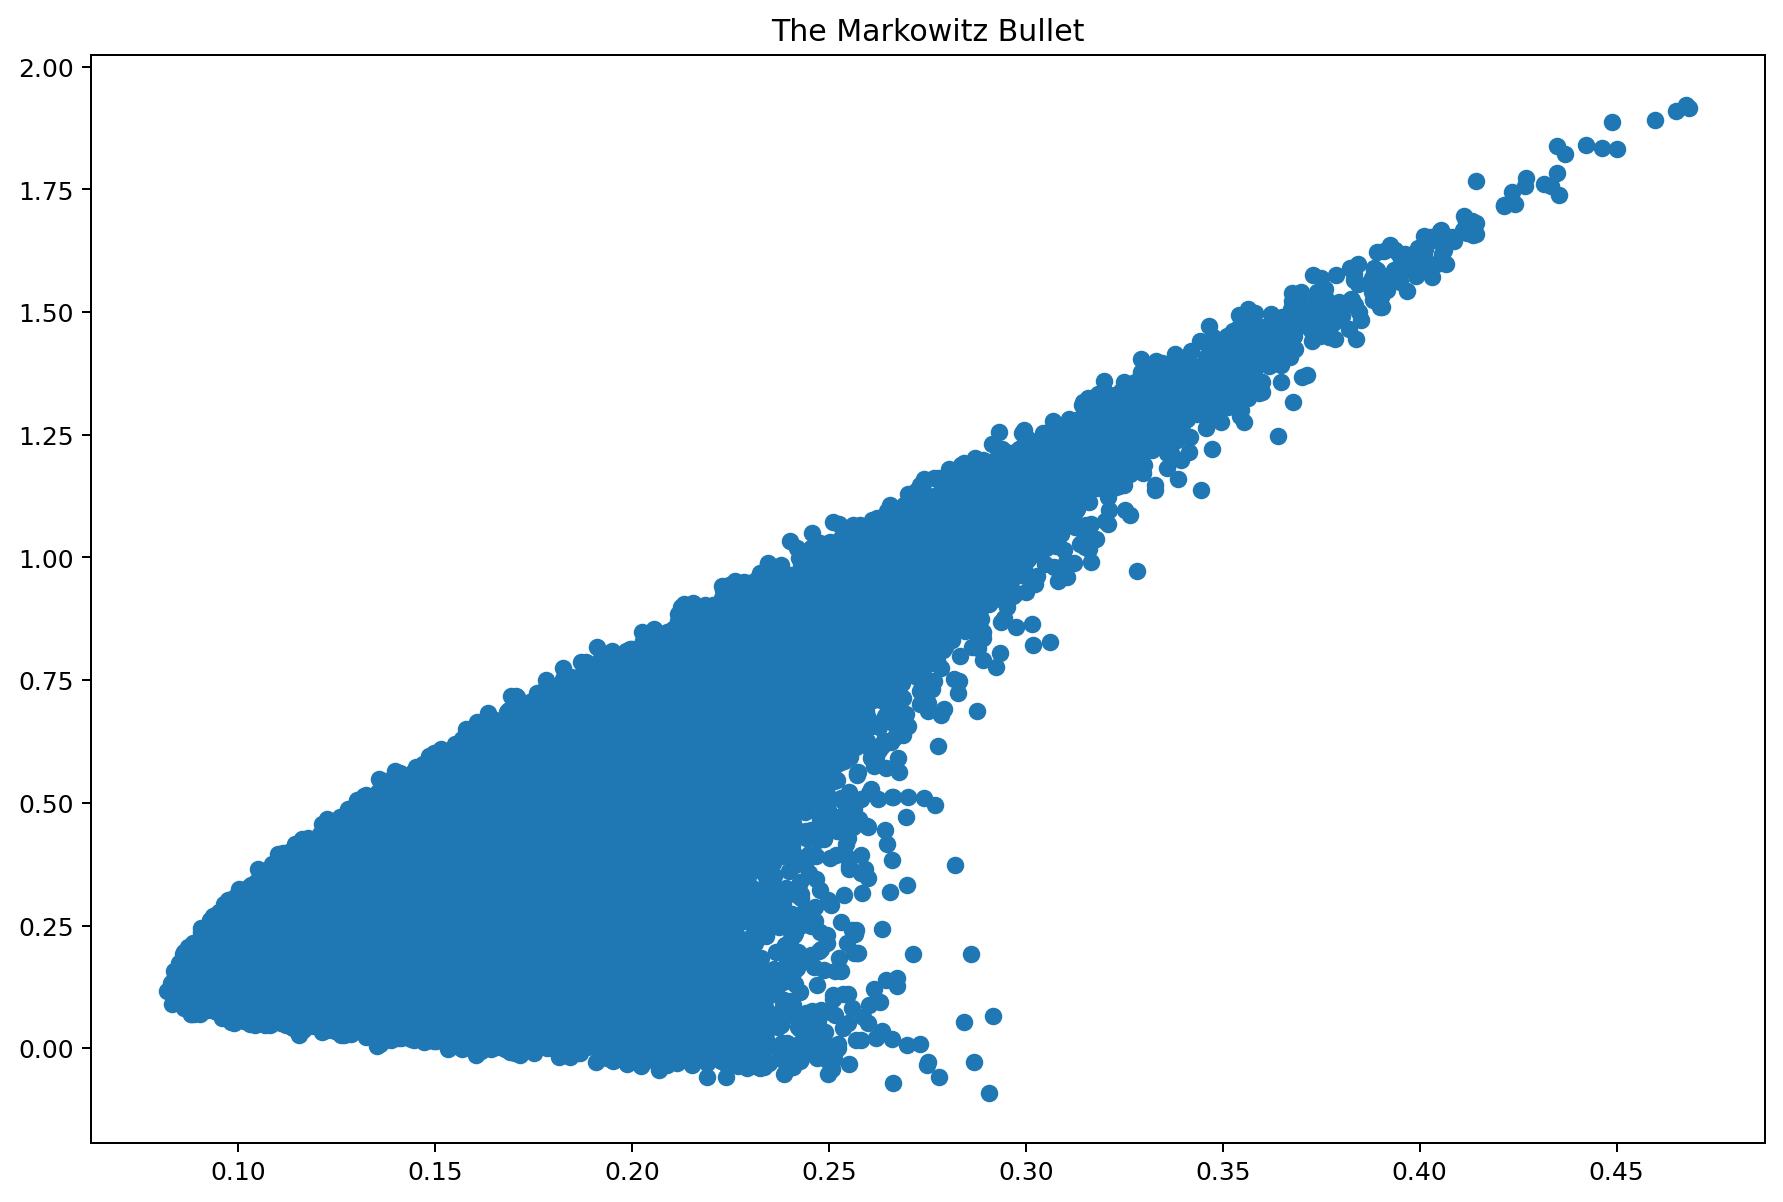

In [62]:
plt.figure(figsize=(12, 8), dpi=180)
plt.title('The Markowitz Bullet')
plt.scatter(*zip(*returns_and_volatilities))

## Optimizing the portfolio
The above plot represents 100.000 different posibilities of how to weight my portfolio, and to chose one, I need to find the "Efficient frontier". This "frontier" is the line that follows the outer mot left egde of the "bullit". In other words, for any portfolio that lies on the "Efficient Frontier", the following is true:<br><br>
<b>"At this expected return, there is no other portfolio, that has less risk than this one."</b><br><br>
This is excactly what I want - to choose an expected return and consider it against the risk I´m running.<br>
I find this frontier, simply by dividing the returns into n bins, and then choose the portfolio with expected return in each bin that has the lowest risk. It might be possible to do this operation by utillizing the scipy.optimize functionality, but for now, this will do.

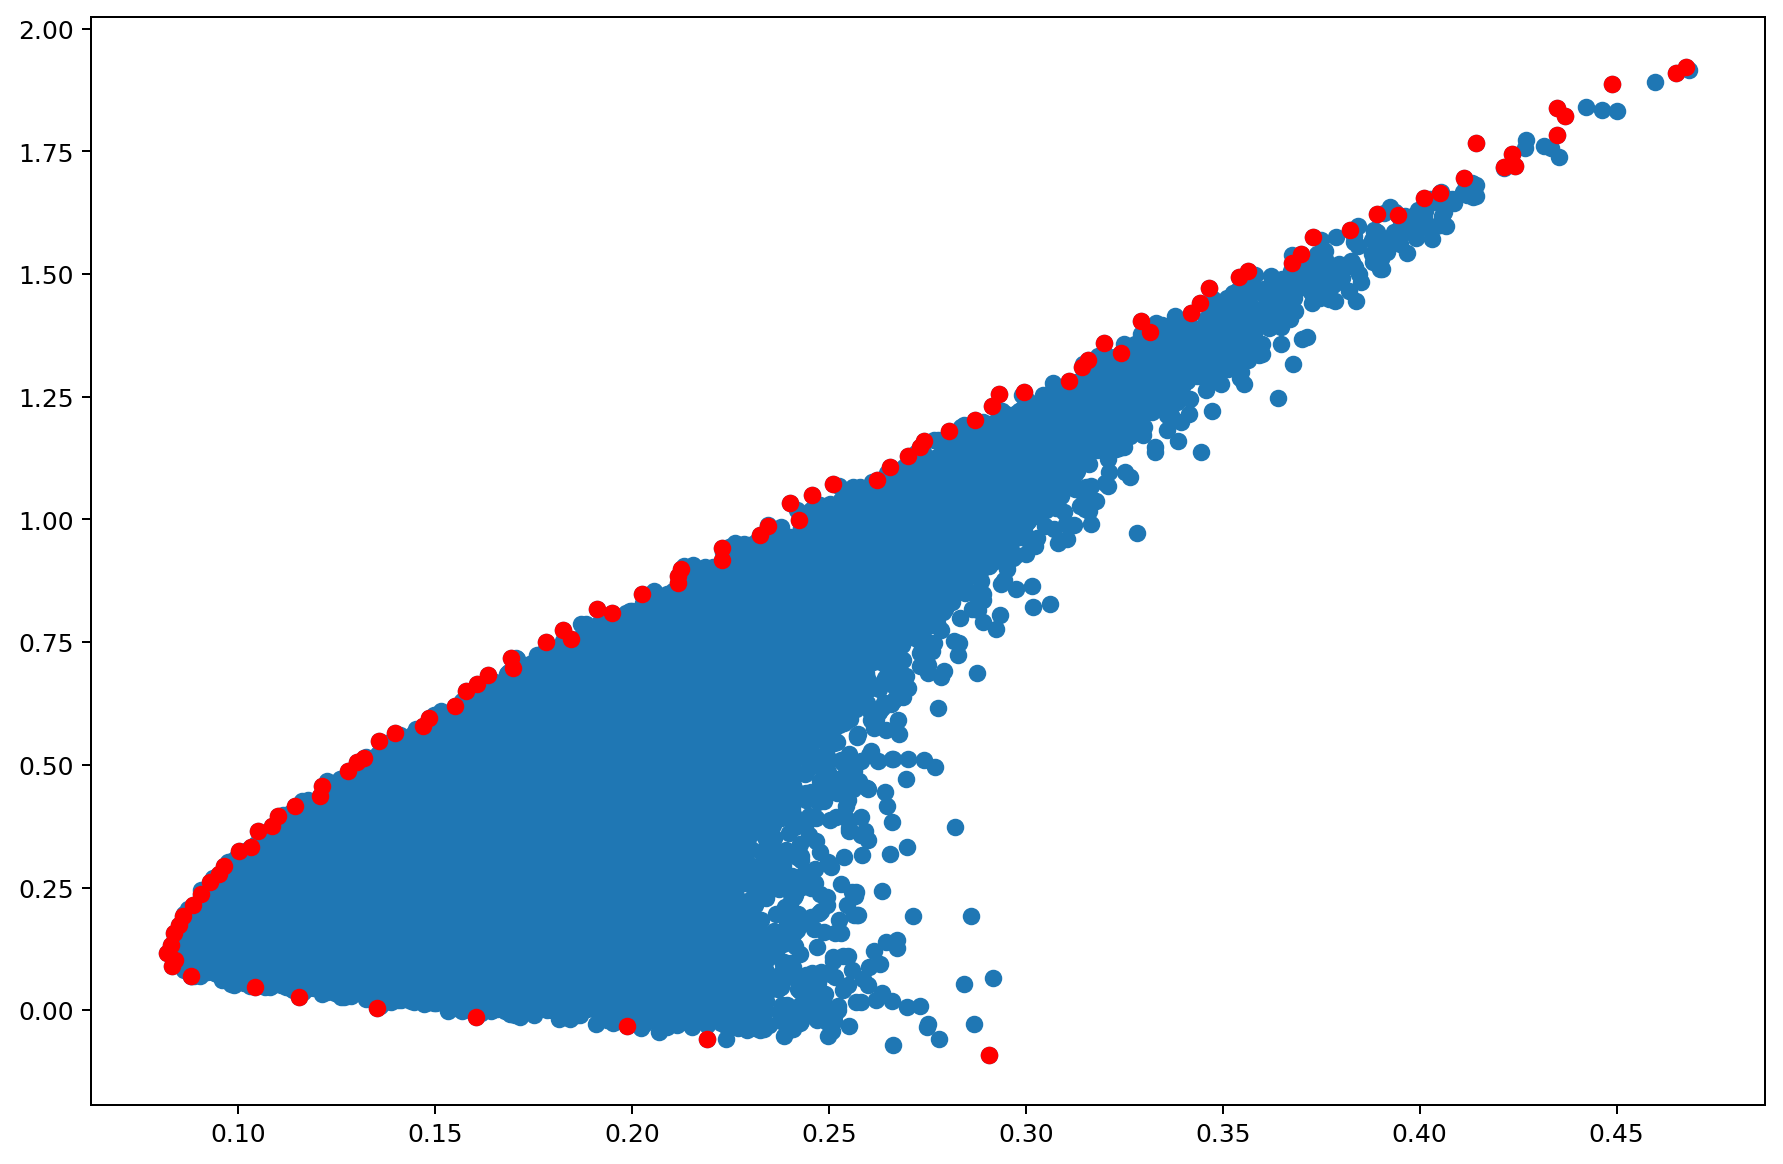

In [63]:
def find_efficiency_frontier(portfolios):
    # Bin all returns into 100 bins
    returns = np.array([portfolio[1] for portfolio in portfolios])
    histogram_bins = np.histogram(returns, bins=100, range=None, normed=None, weights=None, density=None)[1]
    digitized = np.digitize(returns, histogram_bins)
    optimal_portfolios = []
    optimal_portfolio_indexes = []
    
    for i, bin in enumerate(set(digitized)):
        print('Bin {} '.format(i), end='\r')
        filter = [bin == i for i in digitized]
        portfolios_in_bin = np.array(portfolios)[filter]
        best_in_bin = tuple(portfolios_in_bin[np.argmin(portfolios_in_bin[:, 0]), :])    
        optimal_portfolios.append(tuple(portfolios_in_bin[np.argmin(portfolios_in_bin[:, 0]), :]))
    return optimal_portfolios, histogram_bins, i
    
    
optimal_portfolios = find_efficiency_frontier(portfolios)
optimal_returns_and_volatilities = [(p[0],p[1]) for p in optimal_portfolios[0]] # The third is index, so that we ca report back to original
indexes_of_optimal_returns_and_volatilities = [int(p[2]) for p in optimal_portfolios[0]]

# Plot the frontier
plt.figure(figsize=(12, 8), dpi=180)
plt.scatter(*zip(*returns_and_volatilities))
plt.scatter(*zip(*optimal_returns_and_volatilities), color='red')

# To print the bins, include the below step:
if False:
    for y in optimal_portfolios[1]:
        plt.axhline(y=y, color='black', linestyle='-')


The below step creates a Pandas dataframe with all the possible portfolios on the efficient frontier - which are actually the portfolios to choose from, when considering the risk / reward tradeoff that this is all about.

In [64]:
opt = pd.DataFrame(list_of_weights, columns=symbols.keys())
opt = opt.merge(pd.DataFrame(optimal_returns_and_volatilities, columns=['volatility','return']), left_index=True, right_index=True)
opt.sort_values(by='volatility')

,TSLA,TLT,GLD,SPY,QQQ,VWO,IUSR.DE,SXRW.DE,TDC,volatility,return
10,0.076367,0.024512,0.164356,0.219792,0.068190,0.157745,0.018545,0.003170,0.267323,0.081943,0.117404
11,0.019081,0.371370,0.194000,0.048437,0.020052,0.103948,0.145871,0.085563,0.011678,0.082935,0.133345
8,0.029744,0.230298,0.115855,0.095558,0.098666,0.064782,0.084731,0.155534,0.124831,0.083116,0.089479
12,0.082736,0.096016,0.002709,0.016295,0.016665,0.062433,0.041021,0.500994,0.181131,0.083516,0.157886
9,0.082722,0.237946,0.057887,0.080057,0.379255,0.010545,0.047224,0.104075,0.000288,0.083767,0.102955
...,...,...,...,...,...,...,...,...,...,...,...
95,0.187201,0.009151,0.039142,0.210130,0.146146,0.125063,0.237148,0.038969,0.007050,0.434864,1.838056
94,0.080133,0.382645,0.178713,0.050393,0.019642,0.022839,0.105081,0.039995,0.120560,0.436941,1.821051
96,0.034687,0.114539,0.267654,0.063337,0.001873,0.156128,0.232324,0.005378,0.124080,0.448752,1.887251
97,0.019110,0.340348,0.137433,0.097622,0.269420,0.030315,0.031613,0.001285,0.072853,0.465139,1.909011


## What is left is just to choose
From the above collection of possible portfolios, it is possible to choose according to ones appetite for risk. However, another way could be to choose accourding to the "Sharpe Ratio". This philosophy entails two steps:
* Defining the "risk free" interest rate, aka. what would the return be, if I just left the money earning interest in the bank.
* Identify the optimal risk/reward ratio
Now, at todays rates, this risk free interest rate might actually be negative, but this technique still holds. So, the below step calculates the portfolio, that has an expected return that is higher than -0.75% (which is the current rate on cash deposit above 100.000 kr in Spar Nord) and has the best expected return / risk ratio:

In [65]:
opt['sharpe'] = (opt['return']-(-0.0075))/opt['volatility']
sharpe_optimal = opt.iloc[[opt['sharpe'].argmax()]]
sharpe_optimal

,TSLA,TLT,GLD,SPY,QQQ,VWO,IUSR.DE,SXRW.DE,TDC,volatility,return,sharpe
55,0.299994,0.100428,0.019951,0.079347,0.008164,0.050267,0.099712,0.303507,0.03863,0.240072,1.032754,4.333095


I will plot this exact portfolio with a star

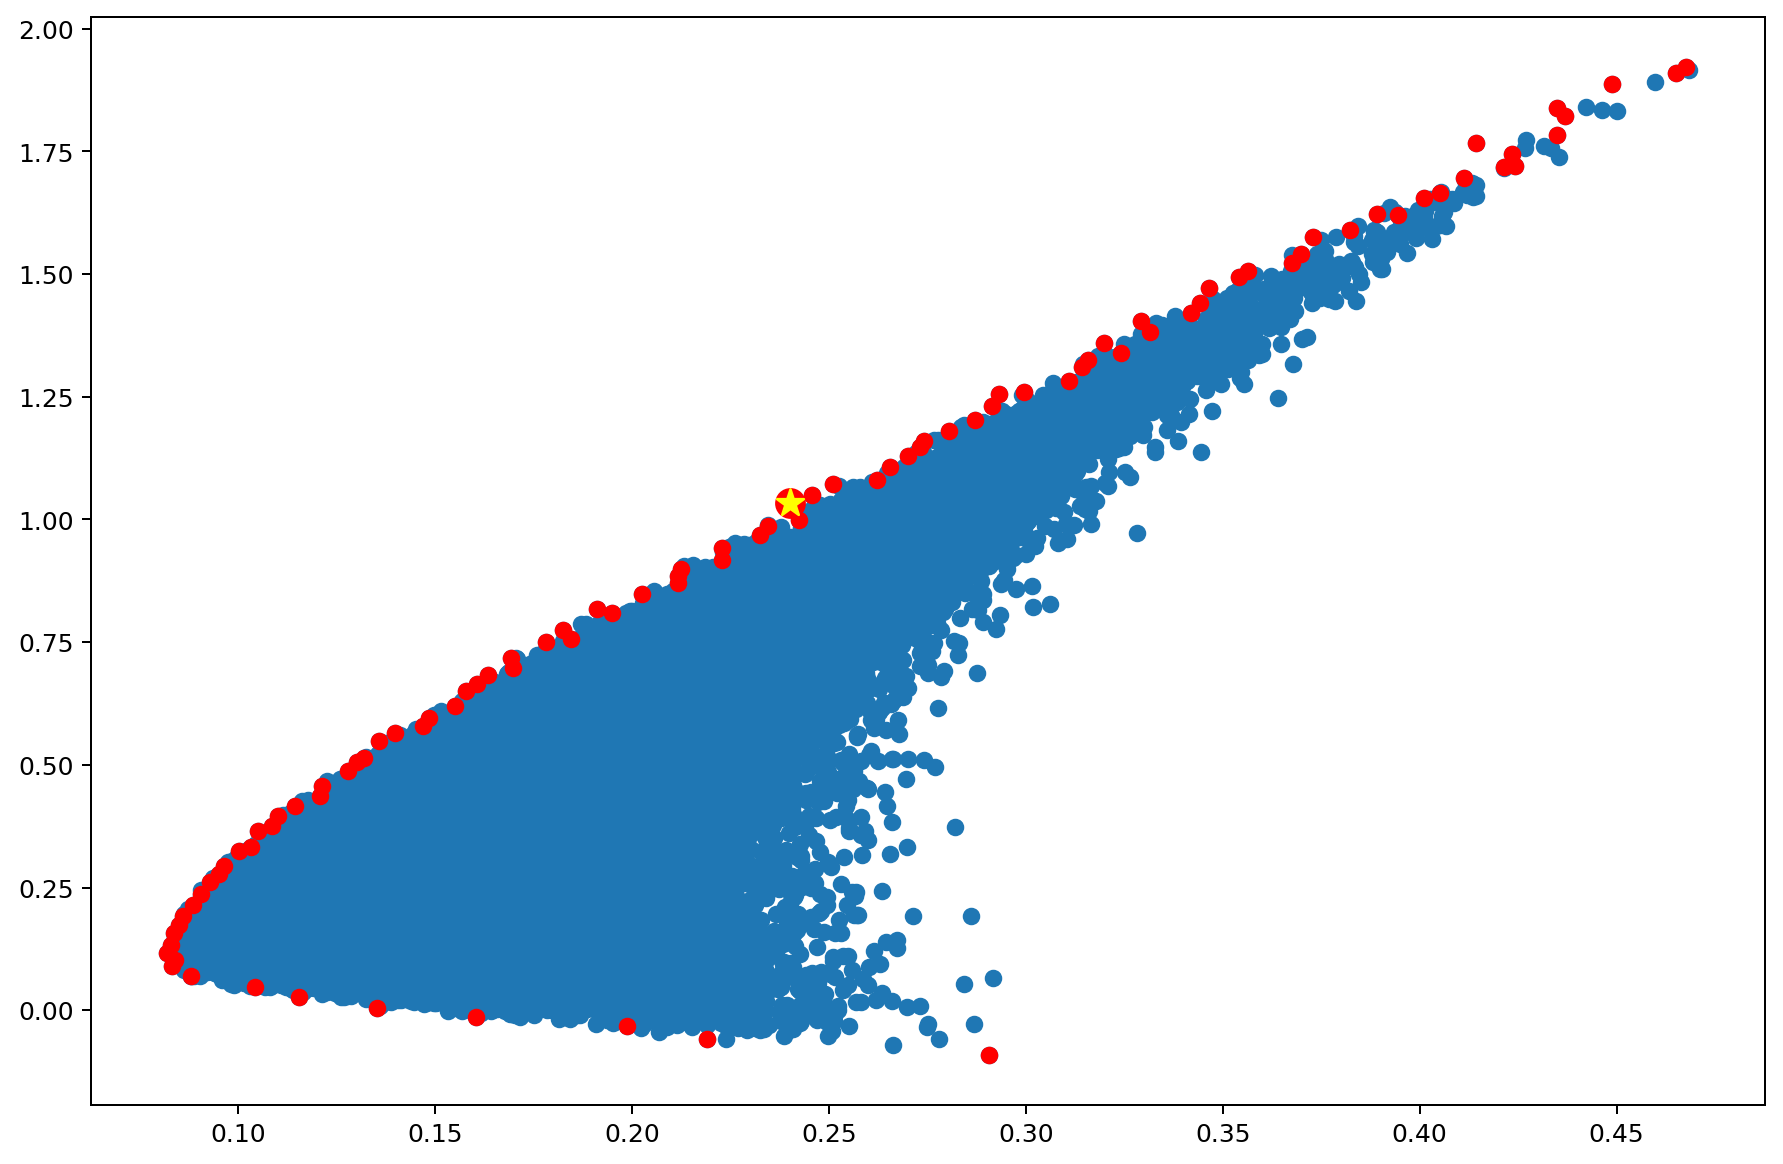

In [66]:
plt.figure(figsize=(12, 8), dpi=180)
plt.scatter(*zip(*returns_and_volatilities))
plt.scatter(*zip(*optimal_returns_and_volatilities), color='red')

plt.scatter(*zip(*sharpe_optimal[['volatility','return']].to_records(index=False)), 
            color='red', s=128)
plt.scatter(*zip(*sharpe_optimal[['volatility','return']].to_records(index=False)), 
            color='yellow', 
            marker='*', s=128)

In [76]:
print('Portfolio expected return: {}'.format(str(round(float(sharpe_optimal['return'])*100))+'%'))

Portfolio expected return: 103%


## Testing the implementation
In theory, this technique should help finding the optimal portfolio weigths. Since there is an element of randomness in this solution, as the individual portfolio weights are randomly generated, repeating the experiments _should_ be gaussian distributed, and also as the number of iterations in individual experiments goes up, the distribution should decrease in std. dev. Lets test this by repeating the experiments 100 times, with two different number of iterations, eg. 5.000 and 50.000. This is going to take a while on a 4 cpu-core laptop, so I'll leave it running through out the night, and pickle the results.

In [52]:
import sys
import pickle
sys.path.insert(1, '../src')

from PortfolioOptimizer import PortfolioOptimizer
tickers = ['TSLA','TLT','GLD','SPY','QQQ','VWO','IUSR.DE','SXRW.DE','TDC']
my_portfolio_optimizer = PortfolioOptimizer(tickers=tickers,
                                                iterations=5000,
                                                risk_free_interest = -0.075,
                                                start = '2018/01/01',
                                                end = '2020/12/31',
                                                number_of_chunks = 10,
                                                number_of_processes = 4,
                                                verbose = 1)

for i in range(0,100):
    print(str(i), end='\n')
    my_portfolio_optimizer.optimize()
    if i == 0:
        first_result = my_portfolio_optimizer.sharpe_optimal
    else:
        first_result = first_result.append(my_portfolio_optimizer.sharpe_optimal)
pickle.dump( first_result, open( "../data/first_result.pkl", "wb" ) )

0
|****************************************************************************************************|100% (5000 iterations) Elapsed time: 00:03:24 Estimated total time: 00:03:24
1
|****************************************************************************************************|100% (5000 iterations) Elapsed time: 00:02:26 Estimated total time: 00:02:26
2
|****************************************************************************************************|100% (5000 iterations) Elapsed time: 00:02:11 Estimated total time: 00:02:11
3
|****************************************************************************************************|100% (5000 iterations) Elapsed time: 00:01:44 Estimated total time: 00:01:44
4
|****************************************************************************************************|100% (5000 iterations) Elapsed time: 00:01:45 Estimated total time: 00:01:45
5
|********************************************************************************************

|****************************************************************************************************|100% (5000 iterations) Elapsed time: 00:01:04 Estimated total time: 00:01:04
91
|****************************************************************************************************|100% (5000 iterations) Elapsed time: 00:01:04 Estimated total time: 00:01:04
92
|****************************************************************************************************|100% (5000 iterations) Elapsed time: 00:01:05 Estimated total time: 00:01:05
93
|****************************************************************************************************|100% (5000 iterations) Elapsed time: 00:01:03 Estimated total time: 00:01:03
94
|****************************************************************************************************|100% (5000 iterations) Elapsed time: 00:01:04 Estimated total time: 00:01:04
95
|*****************************************************************************************

In [53]:
import sys
sys.path.insert(1, '../src')

from PortfolioOptimizer import PortfolioOptimizer
tickers = ['TSLA','TLT','GLD','SPY','QQQ','VWO','IUSR.DE','SXRW.DE','TDC']
my_portfolio_optimizer = PortfolioOptimizer(tickers=tickers,
                                                iterations=25000,
                                                risk_free_interest = -0.075,
                                                start = '2018/01/01',
                                                end = '2020/12/31',
                                                number_of_chunks = 10,
                                                number_of_processes = 4,
                                                verbose = 1)

for i in range(0,100):
    print(str(i), end='\n')
    my_portfolio_optimizer.optimize()
    if i == 0:
        second_result = my_portfolio_optimizer.sharpe_optimal
    else:
        second_result = second_result.append(my_portfolio_optimizer.sharpe_optimal)
pickle.dump(second_result, open( "../data/second_result.pkl", "wb" ) )

0
|****************************************************************************************************|100% (25000 iterations) Elapsed time: 00:05:11 Estimated total time: 00:05:11
1
|****************************************************************************************************|100% (25000 iterations) Elapsed time: 00:05:15 Estimated total time: 00:05:15
2
|****************************************************************************************************|100% (25000 iterations) Elapsed time: 00:05:17 Estimated total time: 00:05:17
3
|****************************************************************************************************|100% (25000 iterations) Elapsed time: 00:05:17 Estimated total time: 00:05:17
4
|****************************************************************************************************|100% (25000 iterations) Elapsed time: 00:05:19 Estimated total time: 00:05:19
5
|***************************************************************************************

|****************************************************************************************************|100% (25000 iterations) Elapsed time: 00:05:13 Estimated total time: 00:05:13
89
|****************************************************************************************************|100% (25000 iterations) Elapsed time: 00:05:19 Estimated total time: 00:05:19
90
|****************************************************************************************************|100% (25000 iterations) Elapsed time: 00:05:17 Estimated total time: 00:05:17
91
|****************************************************************************************************|100% (25000 iterations) Elapsed time: 00:05:16 Estimated total time: 00:05:16
92
|****************************************************************************************************|100% (25000 iterations) Elapsed time: 00:05:19 Estimated total time: 00:05:19
93
|************************************************************************************

NormaltestResult(statistic=14.604988980424807, pvalue=0.0006738557503482423)
0.35638012704716376
***
NormaltestResult(statistic=14.041818068725291, pvalue=0.0008930133439532378)
0.2888979924716838


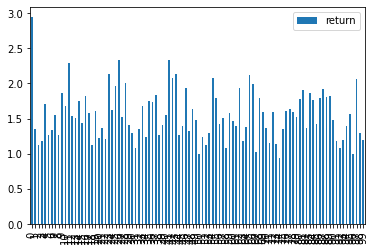

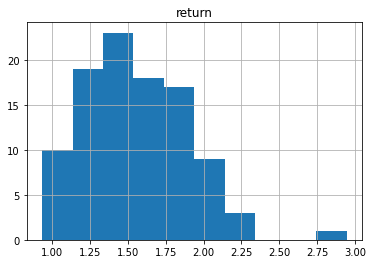

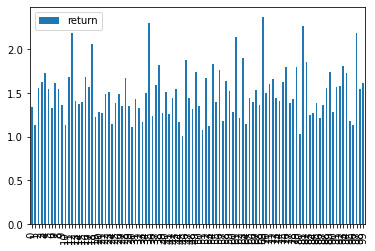

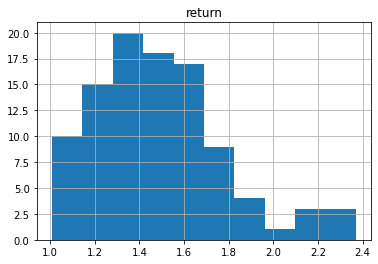

In [60]:
import pandas as pd
from scipy import stats

first_result.reset_index()[['return']].plot(kind='bar')
hist = first_result[['return']].hist(bins=10)
print(stats.normaltest(first_result['return']))
print(first_result['return'].std())
print('***')
second_result.reset_index()[['return']].plot(kind='bar')
print(stats.normaltest(second_result['return']))
hist = second_result[['return']].hist(bins=10)
print(second_result['return'].std())

